In [1]:
# Standard library imports
from timeit import default_timer as timer
from datetime import timedelta
import pickle
from collections import Counter

In [2]:
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
# PyTorch stuff
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# Autoselect target device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [4]:
%load_ext autoreload
%autoreload 2

# Custom modules.

import data_handling as data
import preprocess as pp
from models import nvdm

In [5]:
# # Original data
# DATA_RAW_PATH = "./data/bds_1.txt"
# IDs, BDs = data.load_raw(DATA_RAW_PATH)

In [6]:
# Data that has already been preprocessed, same format as original bds_1.txt.
# Generated by applying pp.preprocess_text() to each BD and saving this to a text file.
DATA_CLEAN_PATH = "./data/bds_1_clean.txt"
IDs_raw, BDs_raw = data.load_raw(DATA_CLEAN_PATH)

In [7]:
# Some entries have empty BDs, so filter those out
IDs = []
BDs = []
for iid, bd in zip(IDs_raw, BDs_raw):
    if len(bd) > 0:
        IDs.append(iid)
        BDs.append(bd)

print(len(IDs), len(BDs))

2034 2034


In [8]:
# This cell shows how the torchtext Vocab was created.
# The object is saved to disk, so this cell only needs to uncommented and run once.
# Build frequency table
# (cleaned data joins tokens by space)
# counter = Counter()
# for desc in BDs:
#     counter.update(desc.split(" "))

# PyTorch torchtext vocabulary converts tokens to indices and vice versa.
# Also has an '<unk>' for OOV words (might be useful later).
# vocab = Vocab(counter,
#               max_size=10000,
#               min_freq=1,
#               specials=['<unk>'])
# print(len(vocab))
# actual is 70770 without max_size restriction

# Save the vocab to file
# with open("./vocabs/vocab_bds_1_clean_10000.pickle", "wb") as f:
#     pickle.dump(vocab, f)

In [9]:
# If the vocab was already created, load the vocab from file.
with open("./vocabs/vocab_bds_1_clean_10000.pickle", "rb") as f:
    vocab = pickle.load(f)

print(len(vocab))

10001


In [10]:
class BDDataset(Dataset):
    """ Very simple dataset object. Stores all the passages.
    
    This is just for compatibility with PyTorch DataLoader.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
# "Preprocessing" function: just splits the text
# The file's text is already preprocessed.
def text_pipeline(text):
    return [vocab[token] for token in text.split(" ")]

def collate_batch(batch):
    """ Convert a batch of text (each a list of tokens) into appropriate torch tensors.
    
    Modification of https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html.
    We don't need labels.
    """
    # Offsets tells the model (which will use EmbeddingBag) where each text starts.
    text_list, offsets = [], [0]
    for _text in batch:
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)

In [12]:
# Create data loader to iterate over dataset in batches during training/evaluation
dataset = BDDataset(BDs)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
hidden_size = 500
num_topics = 10

In [13]:
# Training setup
# Better to run run_nvdm.py in the command line to train than here.
# Uncomment the code below to train if really needed.

# # Total number of epochs
# outer_epochs = 200

# # Epochs for training the encoder/decoder on each alternation.
# inner_epochs = 1

# model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, device)
# model = model.to(device)
# model.train()

# # Trains both the encoder and decoder at the same time.
# # The original paper alternates between the encoder and decoder,
# # but this is very unstable and hard to converge, from observation.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# start_time = timer()

# for epoch in range(outer_epochs):

#     loss_sum = 0.0
#     rec_sum = 0.0
#     kl_sum = 0.0
#     n = len(data_loader)

#     for idx, (text, offsets) in enumerate(data_loader):
#         text = text.to(device)
#         offsets = offsets.to(device)

#         optimizer.zero_grad()
#         loss_dict = model(text, offsets, kl_weight=1.0)
#         loss = loss_dict["total"].sum()
#         loss.backward()

#         optimizer.step()

#         # For printing
#         loss_sum += loss.item()
#         rec_sum += loss_dict["rec"].sum().item()
#         kl_sum += loss_dict["kl"].sum().item()

#     model_str = "All" # "Enc" if switch == 0 else "Dec"
#     print(f"[Time: {timedelta(seconds=timer() - start_time)}, Epoch {epoch + 1}] Loss {loss_sum/n}, Rec {rec_sum/n}, KL {kl_sum/n}")

In [14]:
# Load/save model.

# MODELSAVE_PATH = "./modelsaves/nvdm_from_notebook.pt"
MODELSAVE_PATH = "./modelsaves/nvdm_k10_300epochs.pt"

# Save the trained model to file if needed.
# torch.save(model.state_dict(), MODELSAVE_PATH)

# Otherwise load the model from file if it exists.
# Customize the n_topic (number of topics) according to the file name.
# e.g. "nvdm_k10_300epochs.pt" means n_topic=k=10.
model = nvdm.NVDM(len(vocab), 500, 10, 1, device)
model.load_state_dict(torch.load(MODELSAVE_PATH))
model.eval()

NVDM(
  (embed_bow): EmbeddingBag(10001, 10001, mode=sum)
  (encoder): Sequential(
    (0): Linear(in_features=10001, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Tanh()
  )
  (mu): Linear(in_features=500, out_features=10, bias=True)
  (log_sigma): Linear(in_features=500, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10001, bias=True)
  )
)

In [15]:
# Extract the vocab-topic matrix (known as R in the paper).
# It has dimensions |V| x K: vocab size x number of topics
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone()
weights.size()

torch.Size([10001, 10])

In [16]:
# Look at some words
# manual KNN
from nltk.stem import PorterStemmer
PORTER_STEMMER = PorterStemmer()

# Set of words used in the original paper
candidates = ["weapons", "medical", "companies", "define", "israel", "book"]

for candidate in candidates:
    test_word = PORTER_STEMMER.stem(candidate)
    idx = vocab.stoi[test_word]
    print(test_word, idx)

    # Show top 10 most similar (based on cosine distance)
    sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
    sim_vals, sim_idxs = torch.topk(sims, 15)

    # Show ith nearest word and its score.
    for i, v in zip(sim_idxs, sim_vals):
        print(f"{vocab.itos[i]}\t{v.item()}")
    
    print("-----------")

weapon 6165
weapon	1.0
lightweight	0.9702679514884949
9001	0.9647895097732544
microwav	0.9634866714477539
command	0.9634832143783569
siemen	0.9622424840927124
lockhe	0.9540873765945435
vibrat	0.9501733779907227
missil	0.9498000144958496
radar	0.9496554136276245
traceabl	0.9490392208099365
warfar	0.9485265016555786
newest	0.9478268027305603
disk	0.9477716088294983
alarm	0.947247326374054
-----------
medic 235
medic	1.0
healthcar	0.9052908420562744
health	0.8988372683525085
bodi	0.8922062516212463
care	0.8614827990531921
protocol	0.8437216877937317
fine	0.8426229953765869
patient	0.8412339687347412
safe	0.8239362239837646
countri	0.8223128318786621
certifi	0.8181511759757996
afford	0.8164246082305908
promot	0.8161687254905701
physician	0.8160502910614014
sometim	0.8154329657554626
-----------
compani 3
compani	1.0
corpor	0.9643218517303467
As	0.9592906832695007
offic	0.9515925645828247
manag	0.9451584219932556
quarterli	0.9407287240028381
compris	0.9403908252716064
report	0.9400609135627

In [17]:
# Look at most similar words per topic vector.

V, K = weights.size()
for i in range(K):
    print(f"Topic {i+1}")
    vals, idxs = torch.topk(torch.abs(weights[:, i]), 30)
    for i, v in zip(idxs, vals):
        print(f"{vocab.itos[i]}\t{v.item()}")
    print("------------")

Topic 1
alström	1.7316898107528687
healthlynk	1.7125457525253296
dispensari	1.6805500984191895
tournament	1.6685492992401123
hyperphagia	1.6507813930511475
poker	1.6323144435882568
wager	1.6270204782485962
memo	1.60480797290802
mc4r	1.6041526794433594
fie	1.5912902355194092
setmelanotid	1.5800507068634033
lepr	1.5791690349578857
pjt	1.546424150466919
dbiq	1.5459191799163818
horgo	1.528841257095337
rimegep	1.5258233547210693
pomc	1.5194370746612549
glutam	1.5164963006973267
egm	1.5163019895553589
glori	1.5161906480789185
invesco	1.5161504745483398
marijuana	1.5145869255065918
cgrp	1.511128306388855
triptan	1.5070587396621704
doubletre	1.4993131160736084
wpt	1.499031901359558
greenpro	1.4972460269927979
hilton	1.4966157674789429
heterozyg	1.4954825639724731
lbma	1.4950828552246094
------------
Topic 2
dario	1.624315857887268
ticagrelor	1.5880964994430542
constel	1.547616958618164
geostationari	1.4748482704162598
itu	1.4728652238845825
dsp	1.467491865158081
sef	1.4660618305206299
septic	1

# Part 2 Full Evaluation

In [18]:
def analysis(model):
    """ Qualitative analysis of topic model. """
    
    PORTER_STEMMER = PorterStemmer()
    # Set of words used in the original NVDM paper
    candidates = ["weapons", "medical", "companies", "define", "israel", "book"]
    
    # Extract the vocab-topic matrix (known as R in the paper).
    # It has dimensions |V| x K: vocab size x number of topics
    decoder = model.decoder[0]
    weights = decoder.weight.data.detach().clone()

    for candidate in candidates:
        test_word = PORTER_STEMMER.stem(candidate)
        idx = vocab.stoi[test_word]
        print(test_word, idx)

        # Show top 10 most similar (based on cosine distance)
        sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
        sim_vals, sim_idxs = torch.topk(sims, 15)

        # Show ith nearest word and its score.
        for i, v in zip(sim_idxs, sim_vals):
            print(f"{vocab.itos[i]}\t{v.item()}")

        print("-----------")
    
    V, K = weights.size()
    for i in range(K):
        print(f"Topic {i+1}")
        vals, idxs = torch.topk(torch.abs(weights[:, i]), 30)
        for i, v in zip(idxs, vals):
            print(f"{vocab.itos[i]}\t{v.item()}")
        print("------------")

In [19]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass


def topic_coherence(topic_vocab, n_top_words, pair_score):
    """
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

In [20]:
import os
import re

from nltk.stem import PorterStemmer


MODELSAVE_PATH = "./modelsaves"

models_k = dict()
k_values = []

for filename in os.listdir(MODELSAVE_PATH):
    
    num_topics = filename.split("_")[1][1:]
    num_topics = int(num_topics)
    k_values.append(num_topics)
    
    model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, "cpu")
    model.load_state_dict(torch.load(os.path.join(MODELSAVE_PATH, filename), map_location="cpu"))
    model.eval()
    models_k[num_topics] = model


In [21]:
# Make the BOW matrix manually, using the existing Vocab's token-to-index mapping.
bow_mat = np.zeros((len(BDs), len(vocab)))
for d, bd in enumerate(BDs):
    token_idxs = vocab.lookup_indices(bd.split(" "))
    word_counts = Counter(token_idxs)
    for w, count in word_counts.items():
        bow_mat[d, w] = count   
bow_mat.shape

(2034, 10001)

In [22]:
score_umass_mat = umass_score(bow_mat)

In [23]:
k_values.sort()
tc_values = []

for k in k_values:
    print(f'Running k = {k}')
    this_model = models_k[k]
    
    # Extract the topic vocab matrix
    decoder = this_model.decoder[0]
    weights = decoder.weight.data.detach().clone().numpy()
    topic_vocab_mat = weights.T
    coherences = topic_coherence(topic_vocab_mat, 10, score_umass_mat)
    this_c = np.median(coherences)

    tc_values.append(this_c)

Running k = 5
Running k = 10
Running k = 15
Running k = 20
Running k = 25
Running k = 30
Running k = 35
Running k = 40
Running k = 50


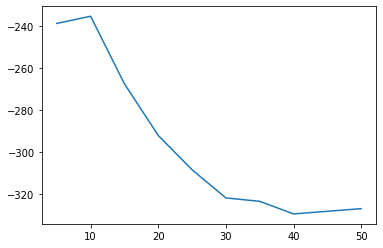

In [24]:
plt.plot(k_values, tc_values);

In [25]:
def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [26]:
feature_names = [vocab.itos[i] for i in range(0, len(vocab))]

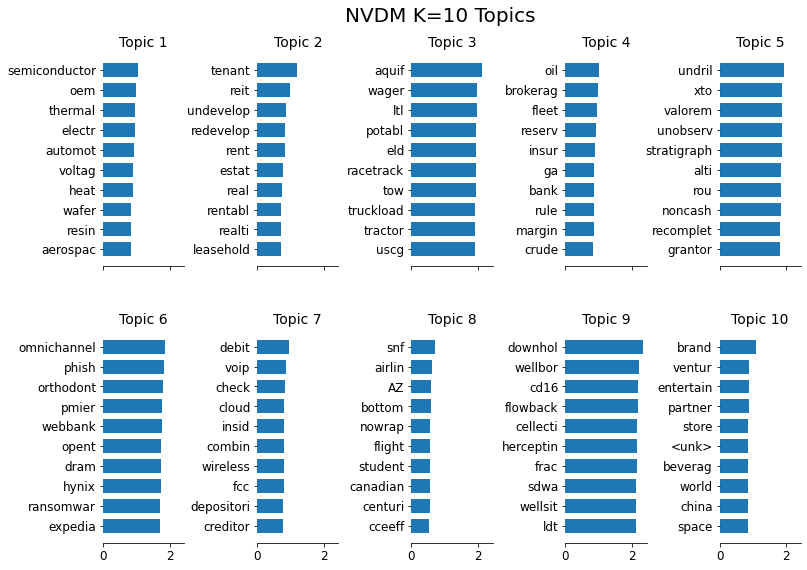

In [27]:
k = 10
this_model = models_k[k]
decoder = this_model.decoder[0]
weights = decoder.weight.data.detach().clone().numpy()
topic_vocab_mat = weights.T

plot_top_words(topic_vocab_mat, feature_names, 10, f"NVDM K={k} Topics")

In [28]:
def perplexity(model, dataset, n_sample):
    """ Compute perplexity of PyTorch model on the PyTorch Dataset. """

    # Iterate over the whole dataset once (1 big batch).
    data_loader = DataLoader(dataset,
                             batch_size=len(dataset),
                             shuffle=False,
                             collate_fn=collate_batch)
    assert len(data_loader) == 1

    for idx, (text, offsets) in enumerate(data_loader):
        text = text.to("cpu")
        offsets = offsets.to("cpu")

        with torch.no_grad():
            

            # Estimate the loss for each document by sampling
            loss_dict = this_model(text, offsets, kl_weight=1.0, n_sample=n_sample)
            loss = loss_dict["total"]

            # According to the NVDM paper, we estimate log probabilities using
            # the variational lower bound (negative of loss).
            log_probs = -loss

            # Perplexity below...
            
            # Hack to get the number of words per document
            # using the offsets (starting index of each document).
            doc_lengths = torch.zeros(offsets.size(0))
            doc_lengths[:-1] = offsets[1:] - offsets[:-1]
            doc_lengths[-1] = text.size(0) - offsets[-1]
            # # Sanity check
            # assert torch.all(torch.tensor([len(bd.split(" ")) for bd in BDs]) == doc_lengths)

            # Average over the words for each document
            ppx_doc = log_probs / doc_lengths

            # Perplexity: argument averages over documents
            ppx = torch.exp(-ppx_doc.mean()).item()

            return ppx

In [30]:
# Compute perplexity example
k = 10
this_model = models_k[k]
this_model = this_model.to("cpu")
this_model.eval()

perplexity(this_model, dataset, 20)

1063.576171875